In [72]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import chainladder as cl
import numpy as np
import os

In [73]:
df = pd.read_csv('./data/processed/reserving_triangle_data.csv')
df.head()

,accident_year,development_year,paid_amount,case_reserve
0,2025,0.0,74263,447647
1,2025,0.0,70403,377244
2,2025,0.0,99,377145
3,2025,0.0,26016,351129
4,2019,1.0,31381,61255


In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153897 entries, 0 to 153896
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   accident_year     153897 non-null  int64  
 1   development_year  153897 non-null  float64
 2   paid_amount       153897 non-null  int64  
 3   case_reserve      153897 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 4.7 MB


In [75]:
df['development_year'] =df['development_year'].astype('Int64')
df.head()

,accident_year,development_year,paid_amount,case_reserve
0,2025,0,74263,447647
1,2025,0,70403,377244
2,2025,0,99,377145
3,2025,0,26016,351129
4,2019,1,31381,61255


In [76]:
df['accident_year'].value_counts()

accident_year
2024    22399
2020    22377
2019    22359
2022    22160
2023    21621
2021    21610
2018    11154
2025    10217
Name: count, dtype: int64

In [77]:
df['incurred_amount'] = df['paid_amount'] + df['case_reserve']
# Clean column names
df.columns = df.columns.str.strip()
df.columns

Index(['accident_year', 'development_year', 'paid_amount', 'case_reserve',
       'incurred_amount'],
      dtype='object')

In [78]:
# Paid triangle
triangle_paid = df.pivot_table(
    index="accident_year",
    columns="development_year",
    values="paid_amount",
    aggfunc="sum"
).fillna(0)

# Case reserve triangle
triangle_case = df.pivot_table(
    index="accident_year",
    columns="development_year",
    values="case_reserve",
    aggfunc="sum"
).fillna(0)

In [79]:
triangle_paid = triangle_paid.cumsum(axis=1)
triangle_case = triangle_case.cumsum(axis=1)

In [80]:
# Example for paid triangle
factors = []
for col in range(len(triangle_paid.columns)-1):
    num = triangle_paid.iloc[:, col+1].sum()
    den = triangle_paid.iloc[:, col].sum()
    factors.append(num/den)

print("Development factors:", factors)

Development factors: [np.float64(1.7858259872013968), np.float64(1.3267492482125791), np.float64(1.1864682927102408), np.float64(1.1126605669806053), np.float64(1.065439025179168), np.float64(1.034867656505333), np.float64(1.0107920581768548)]


In [81]:
# Apply chain ladder to project ultimate losses
triangle_projected = triangle_paid.copy()

for i in range(len(triangle_paid)):
    for j in range(len(factors)):
        if pd.isna(triangle_projected.iloc[i, j+1]):
            triangle_projected.iloc[i, j+1] = triangle_projected.iloc[i, j] * factors[j]

In [82]:
# Ultimate = last column of projected triangle
ultimate = triangle_projected.iloc[:, -1]

# Latest reported (paid + case)
latest_reported = triangle_paid.iloc[:, -1] + triangle_case.iloc[:, -1]

# IBNR = Ultimate - Latest Reported
ibnr = ultimate - latest_reported

reserving_output = pd.DataFrame({
    "Accident Year": ultimate.index,
    "Ultimate Loss": ultimate.values,
    "Latest Reported": latest_reported.values,
    "IBNR": ibnr.values,
    "IBNR %": (ibnr / ultimate * 100).round(2)
})
print(reserving_output)

               Accident Year  Ultimate Loss  Latest Reported          IBNR  \
accident_year                                                                
2018                    2018    375329250.0     8.605312e+08 -4.852020e+08   
2019                    2019    746961674.0     1.765113e+09 -1.018152e+09   
2020                    2020    725130584.0     1.802469e+09 -1.077339e+09   
2021                    2021    662158829.0     1.774342e+09 -1.112184e+09   
2022                    2022    629954057.0     1.882789e+09 -1.252835e+09   
2023                    2023    598477826.0     1.919790e+09 -1.321312e+09   
2024                    2024    546782955.0     2.014133e+09 -1.467350e+09   
2025                    2025    241460993.0     9.917097e+08 -7.502487e+08   

               IBNR %  
accident_year          
2018          -129.27  
2019          -136.31  
2020          -148.57  
2021          -167.96  
2022          -198.88  
2023          -220.78  
2024          -268.36  
202

In [83]:
reserving_output.to_csv('reserving_chain.csv',index=False)

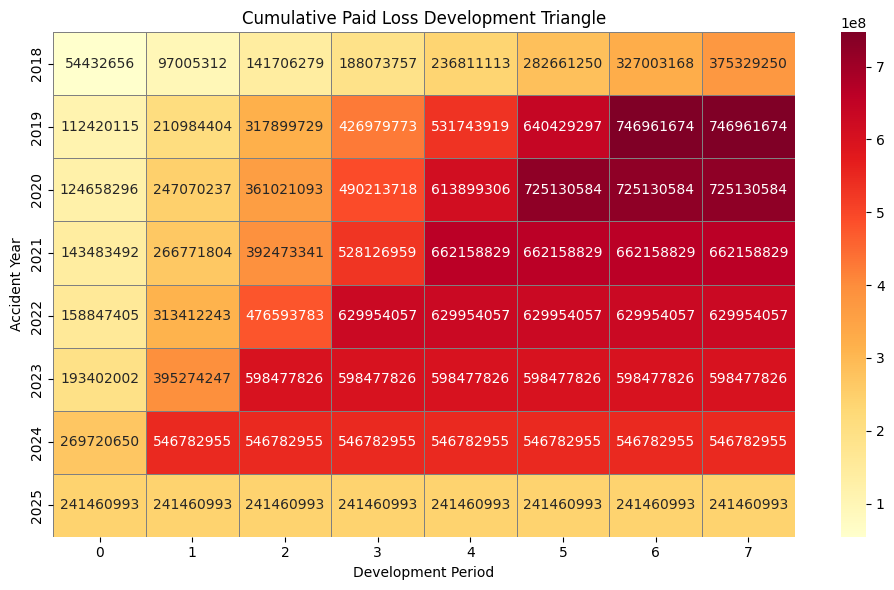

In [84]:
#cumulative paid loss development Triangle
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.heatmap(
    triangle_paid,
    annot=True,
    fmt=".0f",
    cmap="YlOrRd",
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Cumulative Paid Loss Development Triangle")
plt.xlabel("Development Period")
plt.ylabel("Accident Year")

plt.tight_layout()
plt.savefig("./visuals/triangle_paid_heatmap.png", dpi=300)
plt.show()


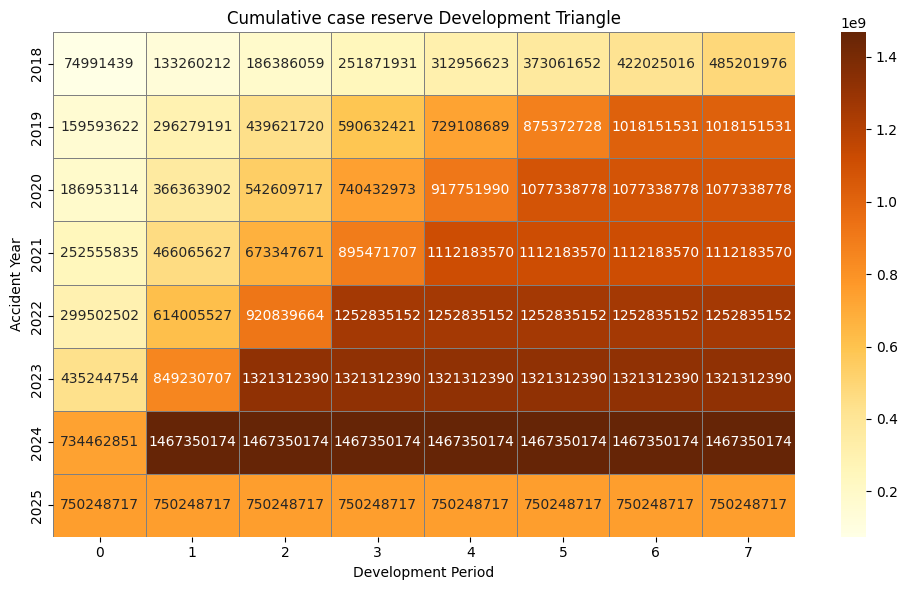

In [85]:
#cumulative case reserve development triangle 
plt.figure(figsize=(10, 6))

sns.heatmap(
    triangle_case,
    annot=True,
    fmt=".0f",
    cmap="YlOrBr",
    linewidths=0.5,
    linecolor="gray"
)

plt.title("Cumulative case reserve Development Triangle")
plt.xlabel("Development Period")
plt.ylabel("Accident Year")

plt.tight_layout()
plt.savefig("./visuals/triangle_case_heatmap.png", dpi=300)
plt.show()